<center> 

<img src="data/Rossemann2.png">


# Rossmann Retail - Use Case 
</center>

By 2015, Rossmann operates over 1,950 drug stores in Germany with almost 20,000 products per store, and it has about 50 million Stock Keeping Units [(SKUs)](https://www.relexsolutions.com/de/news/rossmann-nutzt-scm-software-von-relex/). Currently, Rossmann store managers look forward to improving the assortment in the shells of stores: The objective is to predict their daily sales for up to six weeks in advance.  

The influence of promotions, competition is known. Also, the effect of events like school and state holidays, seasonality, and locality is known.  This work uses macro-economic indicators from Germany like inflation, Consumer Price Index (CPI), and Retail Price Index (RPI) for the pharmaceutical sector.

This notebook review the Rossmann drugstore using two KPI's. 
- __Sales per Visitor__. The idea is to study individual stores by using the total of `Sales` per `Visitors`. The number of `Visitors` is an external variable. This variable relies on an empirical healthy Conversion Rate between 20% and 40%. 
- __Frequency of Visitors and Sales__. Measure the number of `Visitors` per `Minute` in each store. The analysis considers the `Visitors` variable as uniformly distributed. These KPI's is to detect opportunity areas rather than measure current performance

Additionally, this notebook includes external __macro-economical variables__ in Germany and __weather__ data to estimate the demand for six weeks. The original predictions, without external regressors, are the benchmark for the new forecast.

## Loading Data

In [1]:
# prophet by Facebook
from fbprophet import Prophet

import pandas as pd
import numpy as np

from rossmann_metrics import *
from rossmann_eda import *
from rossmann import *
from plots import *

# import seaborn as sns # advanced vizs
# %matplotlib inline

In [2]:
import json
from pandas_profiling import ProfileReport

import warnings
warnings.filterwarnings("ignore")

In [3]:
# sales information for rossmann stores
sales    = pd.read_parquet('data/rossmann_sales.parquet')
sales.Date = pd.to_datetime(sales.Date)

# detailed information for the stores in the reported sales
stores   = pd.read_parquet('data/rossmann_area.parquet')

# detailed information for the location of the stores in the reported sales
geograph = pd.read_parquet('data/rossmann_geographic.parquet')

# detailed information for the opening and closing times of the stores in the reported sales
opening  = pd.read_parquet('data/rossmann_openning.parquet')

# CPI and RPI history for the timeframe in the reported sales in Germany
macro = pd.read_parquet('data/rossmann_macro.parquet')
macro.Date = pd.to_datetime(macro.Date)

# inflation history for the timeframe in the reported sales in Germany
inflation = pd.read_parquet('data/rossmann_inflation.parquet')
inflation.Date = pd.to_datetime(inflation.Date)

# weather history for the timeframe in the reported sales in Germany by State
weather = pd.read_parquet('data/rossmann_weather.parquet')
weather.Date = pd.to_datetime(weather.Date)

# number of visitors of each store estimated values
visitor = pd.read_parquet('data/rossmann_visitors.parquet')
visitor.Date = pd.to_datetime(visitor.Date)

## Exploratory Data Analysis

### Missing Values and Correlations

Quick exploratory analysis of the datasets and the combinations. Looking for null-values and correlations among the KPI's

#### Sales EDA

In [4]:
sales.sample(5)

Date  Store  DayOfWeek  Open   Sales  Customers  Promo  \
317970 2014-11-21    350          5     1  5431.0        447      0   
974299 2015-05-16   1069          6     1  3381.0        445      0   
877564 2014-05-25    963          7     0     0.0          0      0   
155130 2013-03-05    171          2     1  9950.0        999      1   
825843 2015-02-06    907          5     1  6943.0        968      1   

       StateHoliday SchoolHoliday  
317970            0             0  
974299            0             0  
877564            0             0  
155130            0             0  
825843            0             0

__Short description__
- `Date`: The day of the reporting sales at the given store
- `Store`: The number of the store. There are 1115 stores in the dataset
- `DayOfWeek`: A number identifying the day of the week. Starting day _1 = Monday_ until _7 = Sunday_
- `Open`: An indicator for whether the store was open: _0_ = Closed, _1__ = Open
- `Sales`: The turnover for any given day (target variable) in Euros
- `Customers`: The number of customers on a given day in the store
- `Promo`: Indicator if the store is running a promo on that day
- `StateHoliday`: Indicator of a state holiday. Normally all stores, with few exceptions, are closed on state holidays
- `SchoolHoliday`: indicates if the (Store, Date) was affected by the closure of public schools

__Range of dates in the dataset__

In [5]:
get_time_frame_info(data = sales, date_column='Date')

The time frame starts on 2013-01-01 and conclude on 2015-07-31. A total of 941 days


__Missing values__

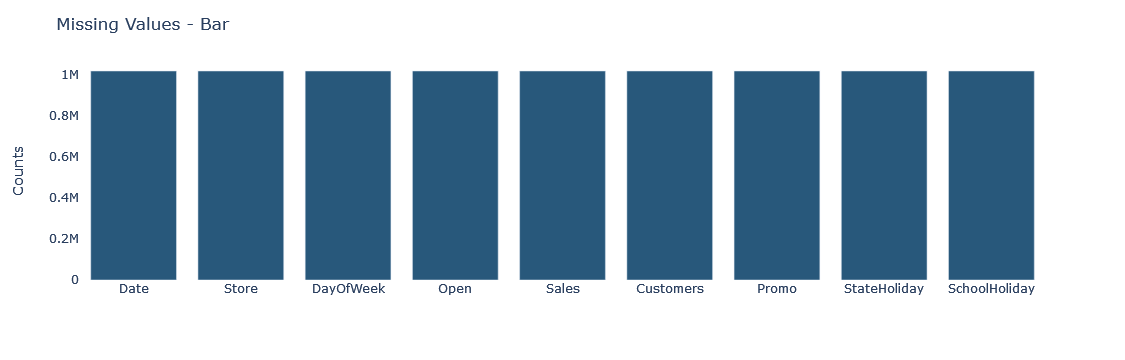

In [6]:
bar_plot(data = sales)

__Correlations__

interval columns not set, guessing: ['DayOfWeek', 'Open', 'Sales', 'Customers', 'Promo']


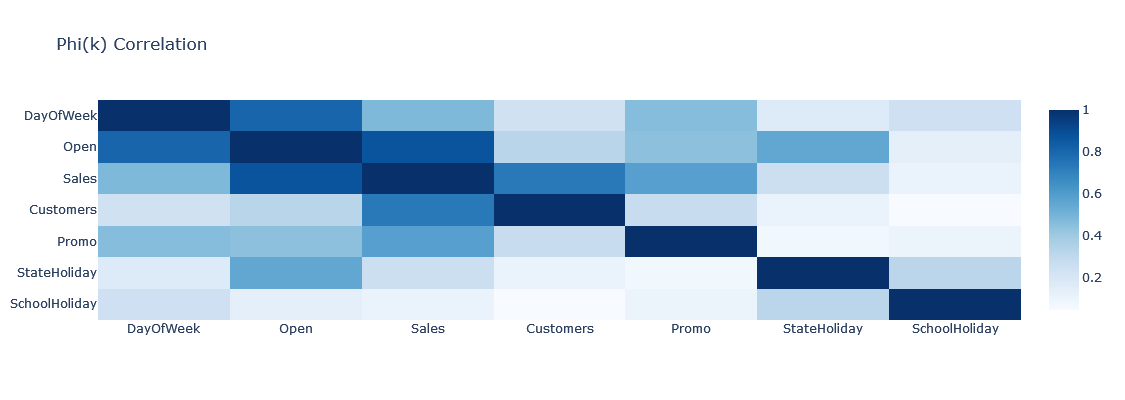

In [7]:
correlation_plot(data=sales.drop(columns=['Date', 'Store']), correlation='phi_k')

__Conclusions:__
- The `sales` dataset is a regular, clean dataset with no missing values
- The time frame of the set is slightly less of the required 3 years for an effective forecast
- Using $\phi(k)$ correlation the conclusion is: `Sales` variable is correlated to `Customers`, `Open`, and `Promo` variables

#### Sales with Macro Economical features EDA

In [8]:
sales_macro = sales.merge(inflation.merge(macro, on='Date'), on='Date')
sales_macro.sample(5)

Date  Store  DayOfWeek  Open   Sales  Customers  Promo  \
648234 2013-11-27     90          3     1  7105.0        959      0   
10383  2015-07-22    349          3     1  6937.0        748      0   
206603 2015-01-27    329          2     1  8475.0        720      1   
610853 2013-12-31    619          2     1  2888.0        300      0   
911185 2013-04-06   1016          6     1  3822.0        421      0   

       StateHoliday SchoolHoliday  Inflation_rate  Inflation_percent    CPI  \
648234            0             0           0.013                1.3   98.8   
10383             0             1           0.002                0.2  100.9   
206603            0             0          -0.003               -0.3   98.1   
610853            0             1           0.014                1.4   99.3   
911185            0             0           0.012                1.2   98.1   

        RPI_pharmacy  RPI_medicin  RPI_cosmetics  
648234          95.0         98.8          100.8  
10383          100.2        100.0          100.0  
206603          99.4         99.7           99.6  
610853          95.1         98.8          100.7  
911185          93.9         99.7          100.7

__Short description (additional features)__
- `Inflation_rate`: A quantitative estimate of the rate at which the decline in purchasing power. Reported as decimal numbers
- `Inflation_percent`: The inflation rate multiplied by a hundred
- `CPI`: The consumer price index for Germany measured as the average price change for all goods and services purchased by households for consumption purposes
- `RPI_pharmacy`: The Retail Price Index (RPI) for the pharmacies in germany
- `RPI_medicin`: The Retail Price Index (RPI) for the medicines and orthopedic equipment in germany
- `RPI_cosmetics`: The Retail Price Index (RPI) for the cosmetics in germany

__Range of dates in the dataset__

In [9]:
get_time_frame_info(data = sales_macro, date_column='Date')

The time frame starts on 2013-01-01 and conclude on 2015-07-31. A total of 941 days


__Missing values__

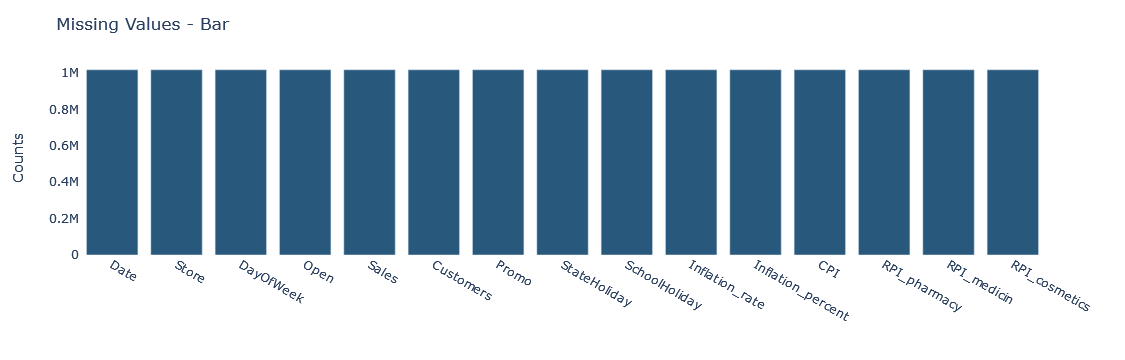

In [10]:
bar_plot(data = sales_macro)

__Correlations__

interval columns not set, guessing: ['DayOfWeek', 'Open', 'Sales', 'Customers', 'Promo', 'Inflation_rate', 'Inflation_percent', 'CPI', 'RPI_pharmacy', 'RPI_medicin', 'RPI_cosmetics']


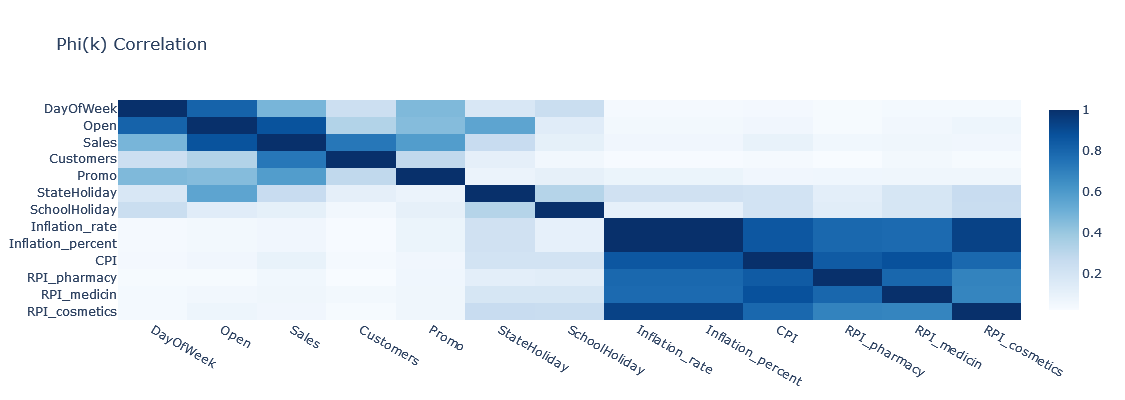

In [11]:
correlation_plot(data=sales_macro.drop(columns=['Date', 'Store']), correlation='phi_k')

__Conclusions:__
- The `sales_macro` dataset is a regular, clean dataset with no missing values. Adding macro-economic data does not alter the consistency of the original data
- The time frame of the set is the same of `sales` with the same warning being less than 3 years
- The $\phi(k)$ correlation diagram shows that none of the new variables from macro-economics seems to have effect on the `Sales`. However, this will be carried to further analysis

#### Sales with Weather features EDA

The `weather` dataset has more records than the original `sales` dataset. The only common column in is dates, misleading the dataframe. Use the `geograph` set to add information about the `State` whete the stor is located and merge using it

In [12]:
auxiliar = geograph[['Store', 'Fullstate', 'State']].merge(sales, on='Store')
sales_weather = auxiliar.merge(weather, on=['Date', 'State'])

In [13]:
sales_weather.sample(5)

Store               Fullstate State       Date  DayOfWeek  Open  \
210651     83  North Rhine-Westphalia    NW 2014-11-24          1     1   
933112    861    Rhineland-Palatinate    RP 2013-05-05          7     0   
364273    239  North Rhine-Westphalia    NW 2013-06-05          3     1   
379683     94  North Rhine-Westphalia    NW 2013-04-12          5     1   
982434     37           Saxony-Anhalt    ST 2013-05-30          4     1   

         Sales  Customers  Promo StateHoliday SchoolHoliday  Max_TemperatureC  \
210651  5225.0        433      1            0             0              11.0   
933112     0.0          0      0            0             0              22.0   
364273  3870.0        351      1            0             0              24.0   
379683  6743.0        646      1            0             0              14.0   
982434  8127.0        881      1            0             0              18.0   

        Mean_TemperatureC  Min_TemperatureC  Max_Humidity  Mean_Humidity  \
210651                6.0               1.0         100.0           81.0   
933112               14.0               7.0         100.0           65.0   
364273               16.0               7.0          96.0           63.0   
379683               11.0               7.0          93.0           76.0   
982434               14.0              11.0          96.0           84.0   

        Min_Humidity  Precipitationmm             Events  
210651          46.0             0.00               Rain  
933112          30.0             0.00             Normal  
364273          27.0             0.00             Normal  
379683          46.0             0.76  Rain-Thunderstorm  
982434          67.0             0.25               Rain

__Short description (additional features)__
- `Fullstate`: Full name of the german state where the store is located
- `State`: Two character abbreviation of the german state where the store is located
- `Max_TemperatureC`: The highest temperature for the given day at the given state in celsius degrees
- `Mean_TemperatureC`: The mean temperature for the given day at the given state in celsius degrees
- `Min_TemperatureC`: The lowest temperature for the given day at the given state in celsius degrees
- `Max_Humidity`: The highest percentage of humidity for the given day in the given state
- `Mean_Humidity`: The mean percentage of humidity for the given day in the given state
- `Min_Humidity`: The lowest percentage of humidity for the given day in the given state
- `Precipitationmm`: Amount of precipitation in mililiters in the given day and given state
- `Events`: A string that describres the type of unique phenomenological event on the given day and state

__Range of dates in the dataset__

In [14]:
get_time_frame_info(data = sales_weather, date_column='Date')

The time frame starts on 2013-01-01 and conclude on 2015-07-31. A total of 941 days


__Missing values__

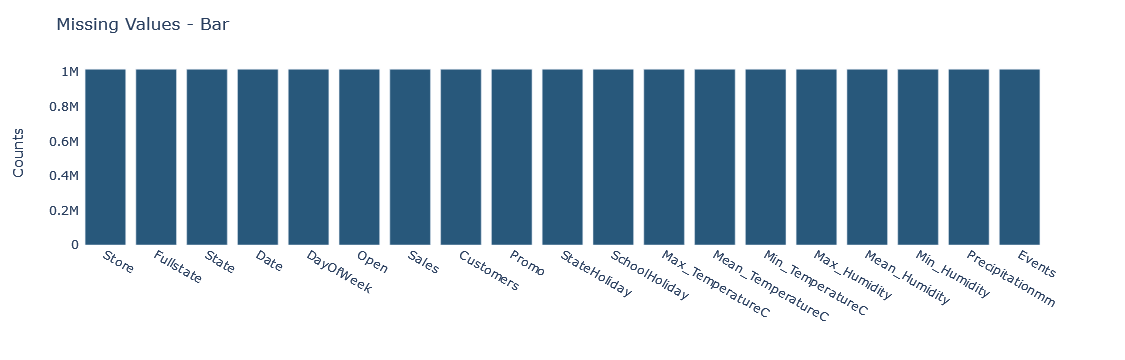

In [15]:
bar_plot(data = sales_weather)

__Correlations__

interval columns not set, guessing: ['DayOfWeek', 'Open', 'Sales', 'Customers', 'Promo', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC', 'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Precipitationmm']


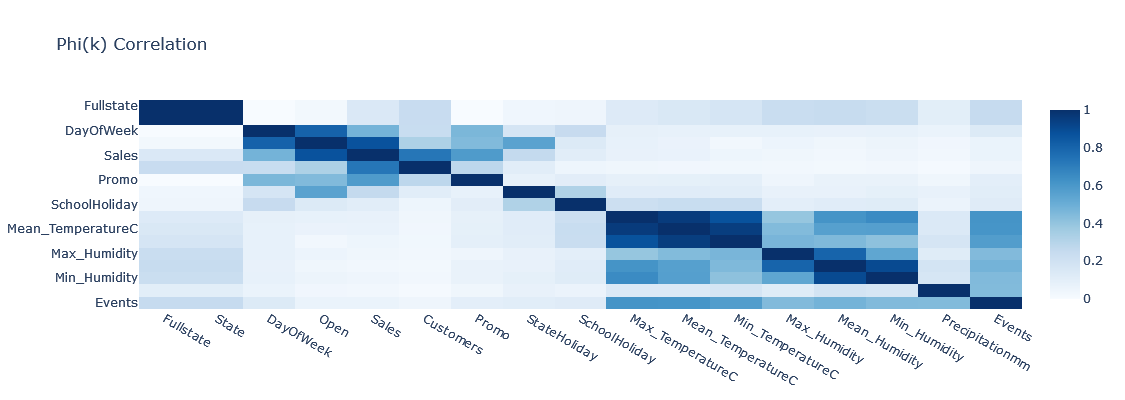

In [16]:
correlation_plot(data=sales_weather.drop(columns=['Date', 'Store']), correlation='phi_k')

__Conclusions:__
- The `sales_weather` dataset is a regular, clean dataset with no missing values. Adding weather information data does not alter the consistency of the original data
- The time frame of the set is the same of `sales` with the same warning being less than 3 years
- The $\phi(k)$ correlation diagram shows that none of the new variables from climate seems to have effect on the `Sales`. However, this will be carried to further analysis

#### Sales with Visitors and Frequency features EDA

In [17]:
auxiliar = sales.merge(visitor, on=['Date', 'Store', 'DayOfWeek', 'Customers'])
sales_visitors = auxiliar.merge(opening, on=['Store', 'DayOfWeek'])

# adding the Extra Variable visitors per minute
sales_visitors['VisitorsPerMinute'] = sales_visitors.Visitors/(sales_visitors.OpenDuration*60)

In [18]:
sales_visitors.sample(5)

Date  Store  DayOfWeek  Open    Sales  Customers  Promo  \
497421 2015-07-14    546          2     1  16750.0       1850      1   
207368 2013-09-03    229          2     1   6076.0        611      0   
748120 2013-02-01    822          5     1   6789.0        609      0   
119023 2015-02-24    131          2     1   3721.0        462      0   
484631 2014-04-04    532          5     1  11066.0       1292      1   

       StateHoliday SchoolHoliday  Visitors  OpenTime  CloseTime  \
497421            0             0      7708       9.0       20.0   
207368            0             0      2444       8.0       20.0   
748120            0             0      2537       8.0       20.0   
119023            0             0      1490       8.5       19.0   
484631            0             0      3915       8.5       19.0   

        OpenDuration  VisitorsPerMinute  
497421          11.0          11.678788  
207368          12.0           3.394444  
748120          12.0           3.523611  
119023          10.5           2.365079  
484631          10.5           6.214286

__Short description (additional features)__
- `Visitors`: The number of visitors on a given day in the store
- `OpenTime`: The oppening time of the given store. It might change according to the day of the week. In 24 hours format
- `CloseTime`: The closing time of the given store. It might change according to the day of the week. In 24 hours format
- `OpenDuration`: The number of hours the store remains open in the particular day.
- `VisitorsPerMinute`: The ratio of `Visitors` over 60 times the `OpenDuration`

__Range of dates in the dataset__

In [19]:
get_time_frame_info(data = sales_visitors, date_column='Date')

The time frame starts on 2013-01-01 and conclude on 2015-07-31. A total of 941 days


__Missing values__

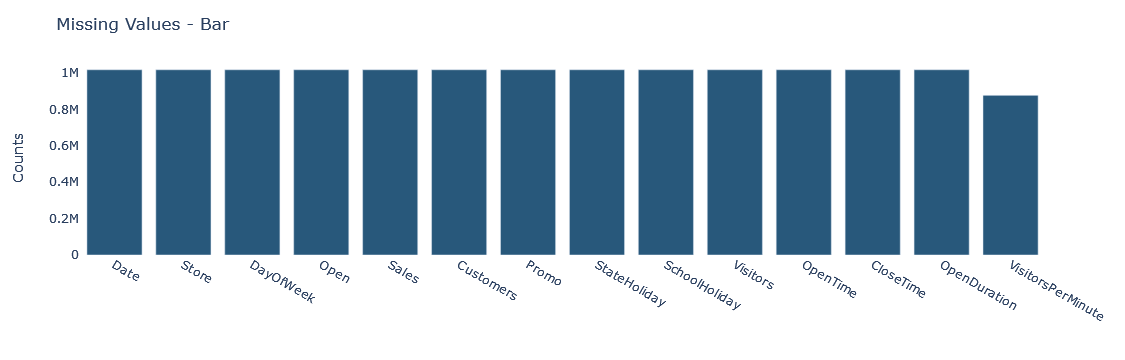

In [20]:
bar_plot(data = sales_visitors)

_Investigating the Missing Values__

In [21]:
sales_visitors[sales_visitors.VisitorsPerMinute.isna()].sample(5)

Date  Store  DayOfWeek  Open  Sales  Customers  Promo  \
371433 2014-06-22    407          7     0    0.0          0      0   
677300 2014-05-18    744          7     0    0.0          0      0   
380427 2015-02-01    417          7     0    0.0          0      0   
258707 2014-03-02    285          7     0    0.0          0      0   
835526 2013-01-13    917          7     0    0.0          0      0   

       StateHoliday SchoolHoliday  Visitors  OpenTime  CloseTime  \
371433            0             0         0       0.0        0.0   
677300            0             0         0       0.0        0.0   
380427            0             0         0       0.0        0.0   
258707            0             0         0       0.0        0.0   
835526            0             0         0       0.0        0.0   

        OpenDuration  VisitorsPerMinute  
371433           0.0                NaN  
677300           0.0                NaN  
380427           0.0                NaN  
258707           0.0                NaN  
835526           0.0                NaN

In [22]:
days = sales_visitors[sales_visitors.VisitorsPerMinute.isna()]['DayOfWeek'].unique().tolist()
print(f"The days where the null values happens: {days}")

The days where the null values happens: [7]


__Correlations__

interval columns not set, guessing: ['DayOfWeek', 'Open', 'Sales', 'Customers', 'Promo', 'Visitors', 'OpenTime', 'CloseTime', 'OpenDuration', 'VisitorsPerMinute']


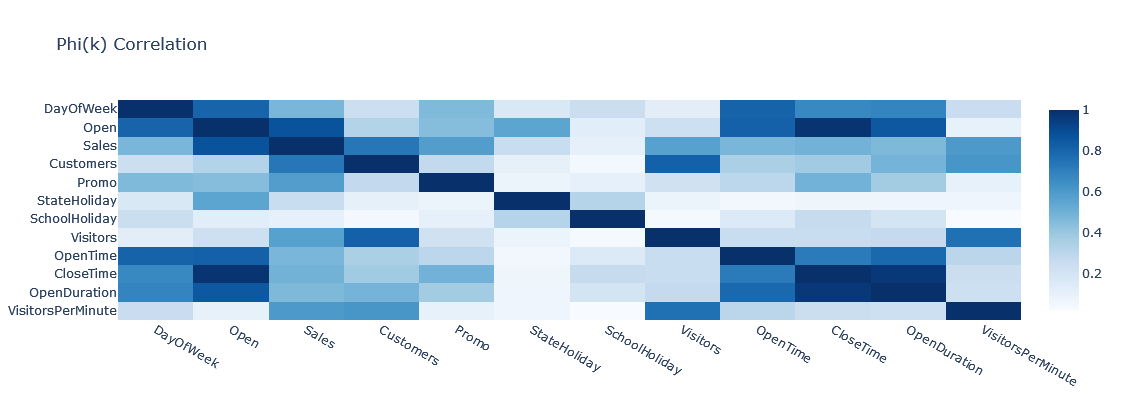

In [23]:
correlation_plot(data=sales_visitors.drop(columns=['Date', 'Store']), correlation='phi_k')

__Conclusions:__
- The `sales_visitors` dataset is regular. The null values happens when the stores are closed usually those on sundays. A replacement value for this entries will be `0` since there weren't visitors on closed stores. No _e-commerce_ considered here
- The time frame of the set is the same of `sales` with the same warning being less than 3 years
- The $\phi(k)$ correlation diagram shows that `Sales` is correlated to `Visitors`, `VisitorsPerMinute`, `OpenTime` and `CloseTime`, and `OpenDuration`

In [24]:
sales_visitors = sales_visitors.fillna(0)

__Add the SalesPerVisitor KPI__

The KPI Sales per Visitor is the sales amount divided by the number of visitors on that store on the particular date.

In [25]:
sales_visitors['SalesPerVisitor'] = sales_visitors['Sales']/sales_visitors['Visitors']

In [26]:
sales_visitors.sample(5)

Date  Store  DayOfWeek  Open    Sales  Customers  Promo  \
54127  2013-04-17     60          3     1   5734.0        617      0   
140716 2014-10-10    156          5     1   6950.0        686      1   
700578 2014-08-09    769          6     1  10760.0       3447      0   
266447 2013-07-10    294          3     1   4321.0        618      0   
721126 2015-02-25    792          3     1   4767.0        554      0   

       StateHoliday SchoolHoliday  Visitors  OpenTime  CloseTime  \
54127             0             0      1713       8.5       20.0   
140716            0             1      2286       8.0       20.0   
700578            0             0     12310       8.0       18.0   
266447            0             1      2131       9.0       19.0   
721126            0             0      1582       8.0       20.0   

        OpenDuration  VisitorsPerMinute  SalesPerVisitor  
54127           11.5           2.482609         3.347344  
140716          12.0           3.175000         3.040245  
700578          10.0          20.516667         0.874086  
266447          10.0           3.551667         2.027687  
721126          12.0           2.197222         3.013274

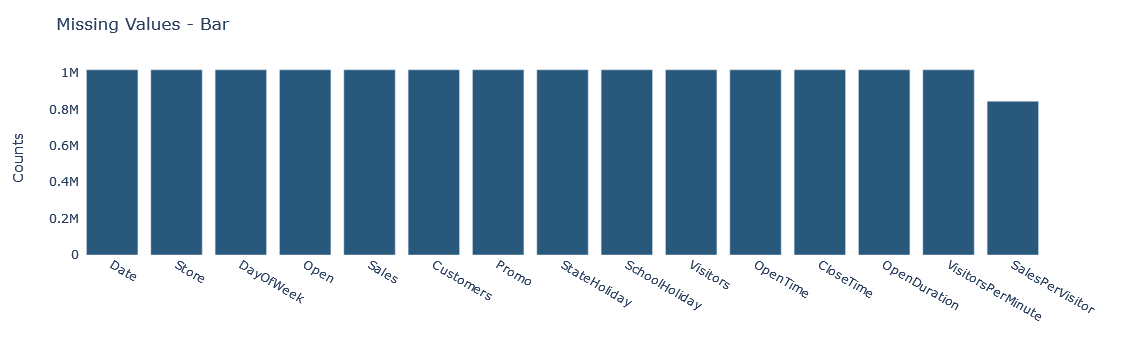

In [27]:
bar_plot(data = sales_visitors)

The missing values corresponds to the `0` from the sundays on visitors. It makes perfect sense to fill the null values with 0. 

In [28]:
sales_visitors = sales_visitors.fillna(0)

__Correlation__

interval columns not set, guessing: ['Customers', 'Visitors', 'Sales', 'SalesPerVisitor', 'VisitorsPerMinute']


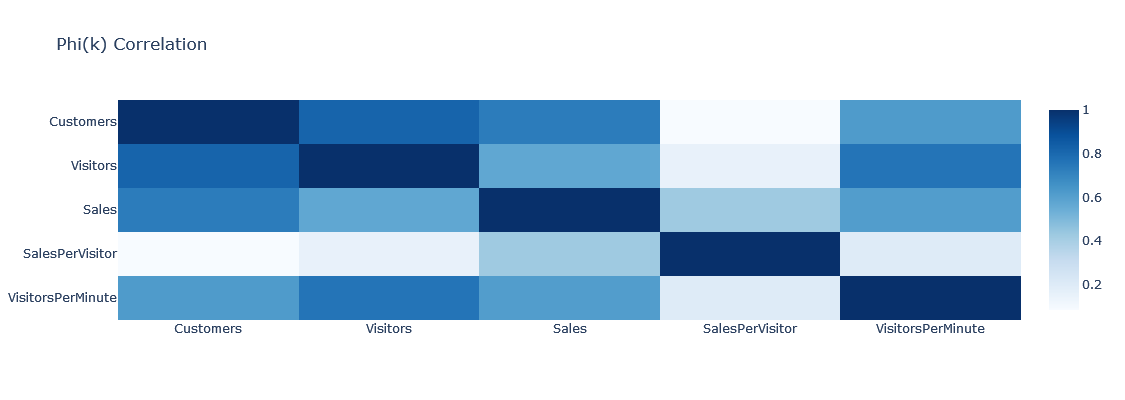

In [29]:
correlation_plot(data=sales_visitors[['Customers', 'Visitors', 'Sales', 'SalesPerVisitor', 'VisitorsPerMinute']], correlation='phi_k')

__Conclusion__
- The new variable `SalesPerVisitor` is correlated to `Sales` as it was expected. This will be use when forecasting as regressors.

### Influence of Promotions

There are two options for a promotion on a given day. This might have an impact on the KPIS. As wee seen above, there seems to be little correlation with `Sales`. However, the promotions are believed to have some effect on the saless

#### Influence on Visitors

In [30]:
sales_promo = sales_visitors.copy()

In [31]:
sales_promo.set_index('Date', inplace=True)
sales_promo['Year'] = sales_promo.index.year
sales_promo['Month'] = sales_promo.index.month
sales_promo['WeekOfYear'] = sales_promo.index.weekofyear
sales_promo.reset_index(inplace=True)

In [32]:
sales_promo = sales_promo.merge(stores, on='Store')

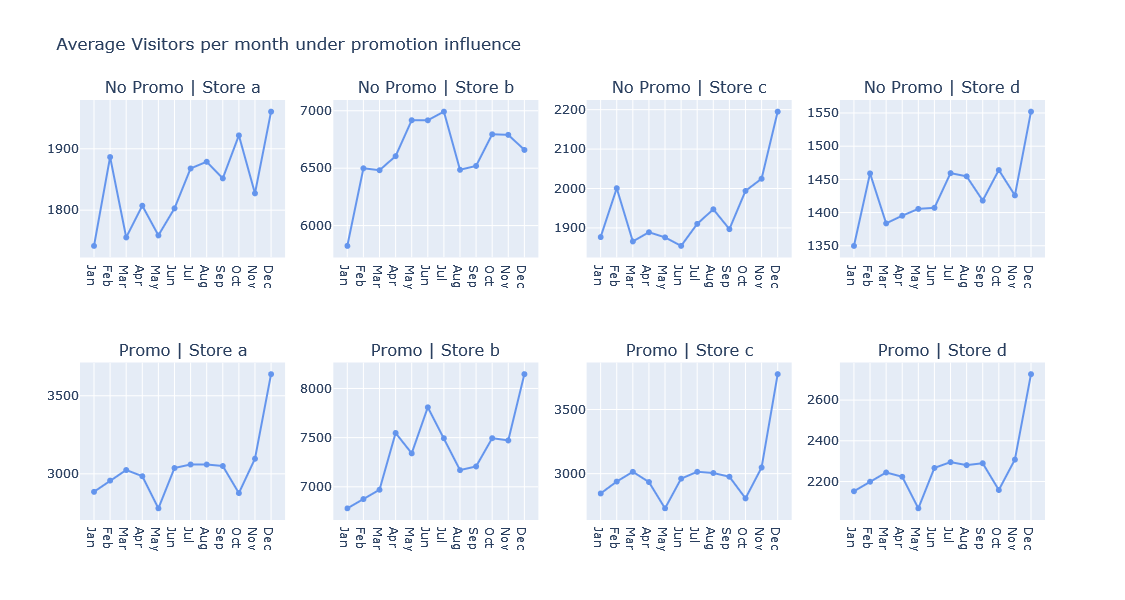

In [33]:
# Try for kpis = 'Visitors', 'Consumers', 'VisitorsPerMinute', 'Sales', and 'SalesPerVisitor'
plot_monthly_kpis_under_promo(data=sales_promo, kpi='Visitors')

__Conclusion:__
- A segmentation on the type of store under influence of promotion, the number of average monthly `Visitors` has a higher level when there are promotions
- The overall pattern changes when a promotion is at Rossmann, but the trend seems to remain for the whole year. This might be effect of the time series itself

#### Influence on Customers

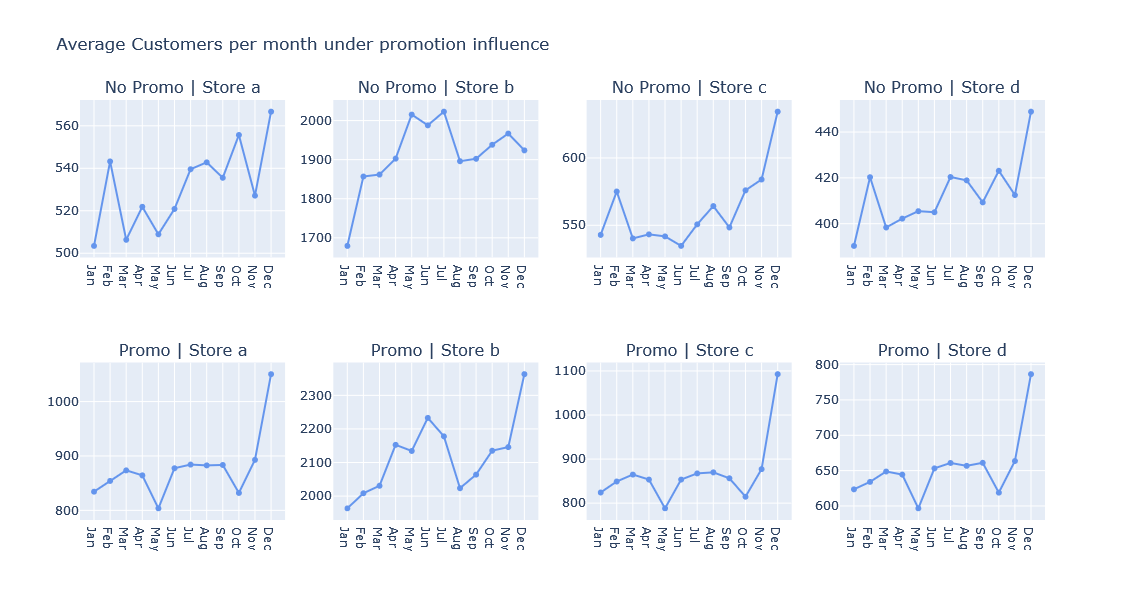

In [34]:
# Try for kpis = 'Visitors', 'Consumers', 'VisitorsPerMinute', 'Sales', and 'SalesPerVisitor'
plot_monthly_kpis_under_promo(data=sales_promo, kpi='Customers')

__Conclusion:__
- A segmentation on the type of store under influence of promotion, the number of average monthly `customers` has a higher level when there are promotions
- The overall pattern changes when a promotion is at Rossmann, but the trend seems to remain for the whole year. This might be effect of the time series itself
- `Customers` is strongly related to `Visitors`, therefore such behaviur is expected

#### Influence on other KPI's

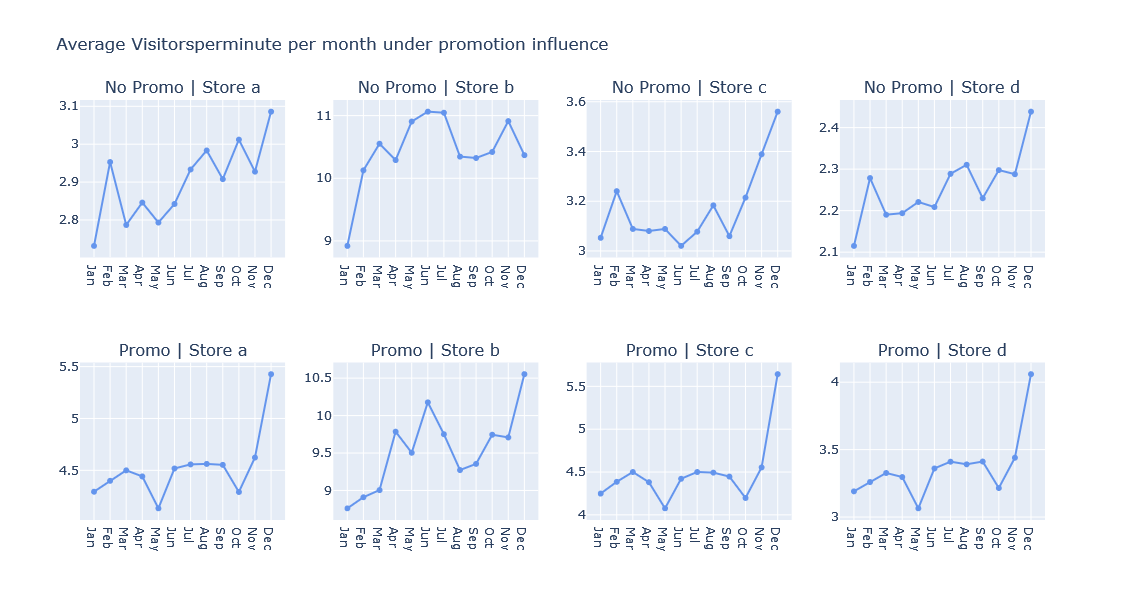

In [35]:
# Try for kpis = 'Visitors', 'Consumers', 'VisitorsPerMinute', 'Sales', and 'SalesPerVisitor'
plot_monthly_kpis_under_promo(data=sales_promo, kpi='VisitorsPerMinute')

__Conclusion:__
- As `Sales`, `SalesPerVisitor` and `VisitorsPerMinute` are correlated to `Visitors` the same observations remain true for those kpi's

## Time Series Analysis - All stores

The methodology for the time series analysis consists of:
1. Aggregate the total sales of all stores weekly on Fridays
2. Do time series Analysis for the aggregated set
3. Use Prophet to forecast 6 weeks of sales in Rossmann

The evaluation metric for the forecast is the relative root mean squared error (R-RMSE) defined as:

<center>$\text{R-RMSE}=\frac{\sqrt{\frac{\sum{(y-\hat{y})^2}}{N}}}{\sum{y/{N}}}$ </center>  


The larger the difference indicates a larger gap between the predicted and observed values, which means poor regression model fit. In the same way, the smaller RMSE that indicates the better the model.

### Time Series Decomposition

In [36]:
subsales_macro = sales_macro[['Date', 'Sales', 'Inflation_rate', 'Inflation_percent', 'CPI', 'RPI_pharmacy', 'RPI_medicin', 'RPI_cosmetics']]
subsales_macro.rename(columns={'Date': 'ds', 'Sales': 'y'}, inplace=True)

In [37]:
subsales_macro.set_index('ds', inplace=True)
subsales_macro = subsales_macro.resample('W-Fri').agg({'y': np.sum, 
                                                       'Inflation_rate': np.mean, 
                                                       'Inflation_percent': np.mean,
                                                       'CPI': np.mean, 
                                                       'RPI_pharmacy': np.mean, 
                                                       'RPI_medicin': np.mean, 
                                                       'RPI_cosmetics': np.mean})

In [38]:
subsales_macro.sample(5)

y  Inflation_rate  Inflation_percent        CPI  \
ds                                                                     
2014-09-26  30509051.0        0.008000           0.800000  99.700000   
2014-07-04  49824675.0        0.008944           0.894425  99.505575   
2014-09-05  44388600.0        0.008000           0.800000  99.700000   
2014-11-14  41487069.0        0.006000           0.600000  99.300000   
2013-01-04  20033838.0        0.017000           1.700000  97.500000   

            RPI_pharmacy  RPI_medicin  RPI_cosmetics  
ds                                                    
2014-09-26     99.100000    99.600000     100.800000  
2014-07-04     97.866902    99.552788     100.741637  
2014-09-05     99.071429    99.628571     100.742857  
2014-11-14     99.400000    99.700000     100.600000  
2013-01-04     93.100000    99.100000     100.800000

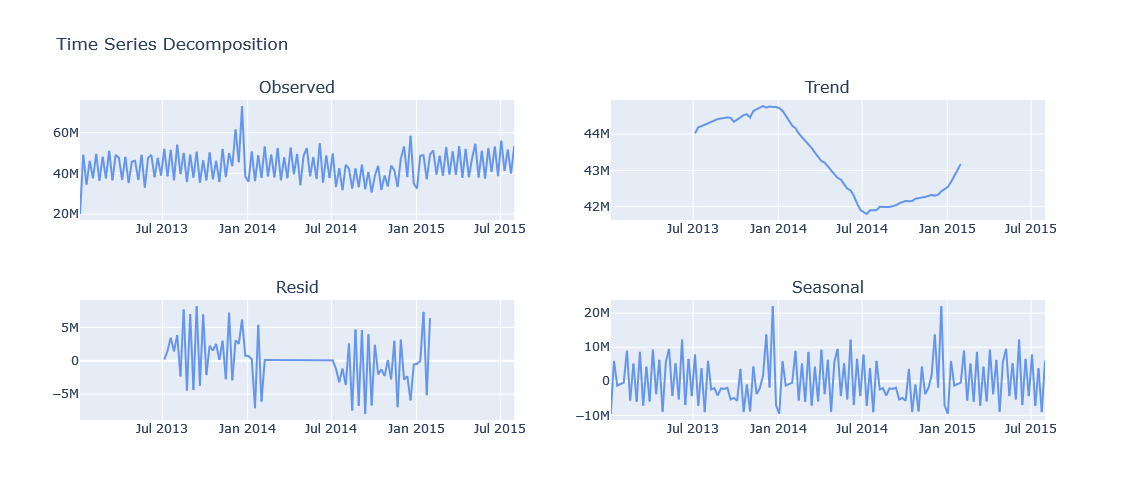

In [39]:
get_time_series_decomposition(time_series=subsales_macro.y)

__Conclusion__
- The total sales has a change in trend in three steps: From Second semester of 2013 it has a growing trend until January 2014. It follows a well defined decreasing trend to it's minimum on July 2014. Lastly, it shows an increasing pattern from july to January as in the first step
- There are a clearly yearly seasonal pattern. The highest picks for the months of December and January with a stable up-down variation for the comming months until July and Augsut when it clearly flatten the pattern. It finish with a regular increasing pattern for the rest of the year

In [40]:
# Global variables for evaluating and predicting
subsales_macro.reset_index(inplace=True)
length = len(subsales_macro.y)

### Forecasting Models with Macroeconomical features using Prophet

#### Predicting without regressors (Benchmark)

Description of the model:
1. Prophet model with confidence interval: `75%`
2. Predicted Variable: `Sales`
3. Regressors: None
3. Periods: 6 weeks ahead

In [41]:
model = Prophet(interval_width = 0.75)
model.fit(subsales_macro)

# Set the future dataframe to have the weekly frequency. Prophet does it on a daily basis
future = pd.DataFrame({'ds': pd.date_range('2013-01-01', '2015-09-25', freq='W-Fri')})
forecast1 = model.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


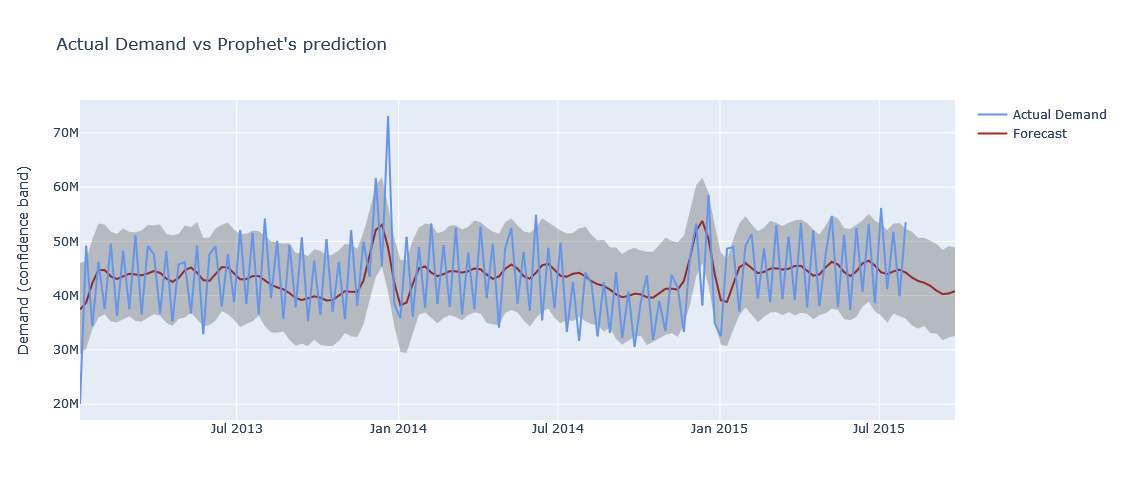

In [42]:
get_plot_prediction_from(forecast=forecast1, actual = subsales_macro)

In [43]:
actual = subsales_macro.y
fitted = forecast1.yhat[:length]
get_forecast_evaluation(actual=actual, fitted=fitted)['R-RMSE']

0.16837634065717025

__Conclusion:__
- The model gives `R-RSME = 0.1683` (rounding numbers 16.8 %) as benchmark threeshold for the different models
- The benchmark score is considered a good score for predictions. Hence, the raw model without regresor is good predicted by Prophet

#### Predicting with Inflation rate regressor

Higher inflation rates erode purchasing power, making it less likely that consumers have excess income to spend after covering basic expenses such as food and housing. Higher price tags on consumer goods also deter spending [Investopedia](https://www.investopedia.com/ask/answers/042815/which-economic-factors-most-affect-demand-consumer-goods.asp)

The first regressor to check is inflation. In the correlation section, the `Inflation_rate` is not correlated with the `Sales` variable. However, some aggregation might influenced this behaviour and because inflation is a relevant variable it is included in the model

Description of the model:
1. Prophet model with confidence interval: `75%`
2. Predicted Variable: `Sales`
3. Regressors: `Inflation_rate`
3. Periods: 6 weeks ahead

In [44]:
model = Prophet(interval_width = 0.75)

# add Inflation_rate as a regressor
model.add_regressor('Inflation_rate')

# fit the model
model.fit(subsales_macro)

# dataFrame for the prediction
future = model.make_future_dataframe(periods=56)
future['Inflation_rate'] = inflation['Inflation_rate']
future = future.set_index('ds').resample('W-Fri').mean()
future.reset_index(inplace=True)

forecast2 = model.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


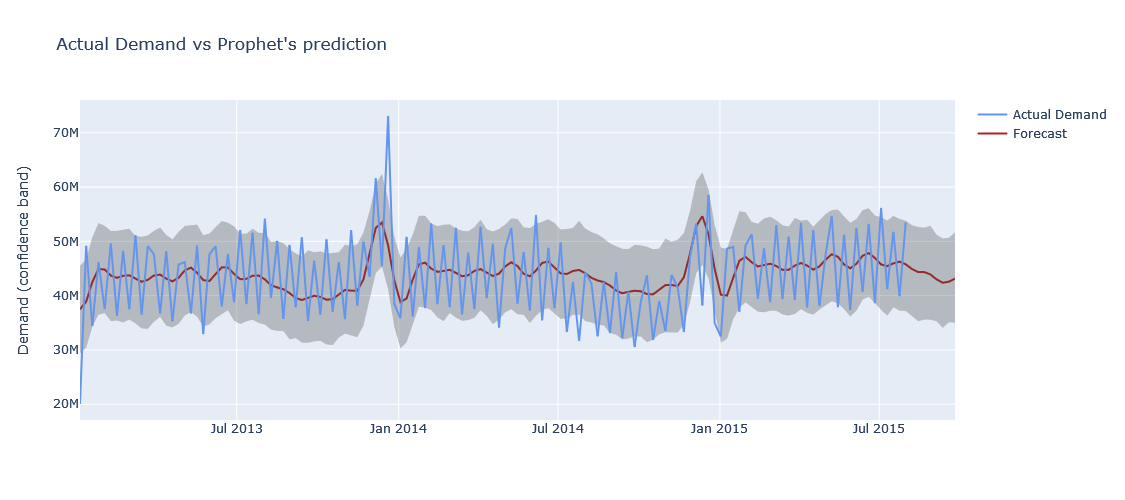

In [45]:
get_plot_prediction_from(forecast=forecast2, actual = subsales_macro)

In [46]:
actual = subsales_macro.y
fitted = forecast2.yhat[:length]
get_forecast_evaluation(actual=actual, fitted=fitted)['R-RMSE']

0.16902523065167968

__Conclusion:__
- The model gives `R-RSME = 0.1690` (rounding numbers 16.9 %).
- The model with `Inflation_rate` as a regressor is performing sligthtly worse, by a marginal 0.01 % than the model without regressors.
- It is still a good model.

#### Predicting with Inflation rate and RPI for pharmacy regressors

The Retail Price Index (RPI) is a world-famous statistic used to track inflation. It has beed deprecated as a unique estimator of inflation. In spite of its name (Retail) the RPI tracks all household spending, including travel, entertainment and leisure, not just spending on merchandise in shops and e-commerce.

In the current data, RPI is present by sector. The Pharmacy RPI is used as regressor in combination with the inflation rate.

Description of the model:
1. Prophet model with confidence interval: `75%`
2. Predicted Variable: `Sales`
3. Regressors: `Inflation_rate`, `RPI_Pharmacy`
3. Periods: 6 weeks ahead

In [47]:
model = Prophet(interval_width = 0.75)

# add RPI_pharmacy and Inflation_rate as predictors
model.add_regressor('RPI_pharmacy') 
model.add_regressor('Inflation_rate')
model.fit(subsales_macro);

# dataFrame for the prediction
future = model.make_future_dataframe(periods=56)

future['RPI_pharmacy'] = macro['RPI_pharmacy']
future['Inflation_rate'] = inflation['Inflation_rate']

future = future.set_index('ds').resample('W-Fri').mean()
future.reset_index(inplace=True)

forecast3 = model.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


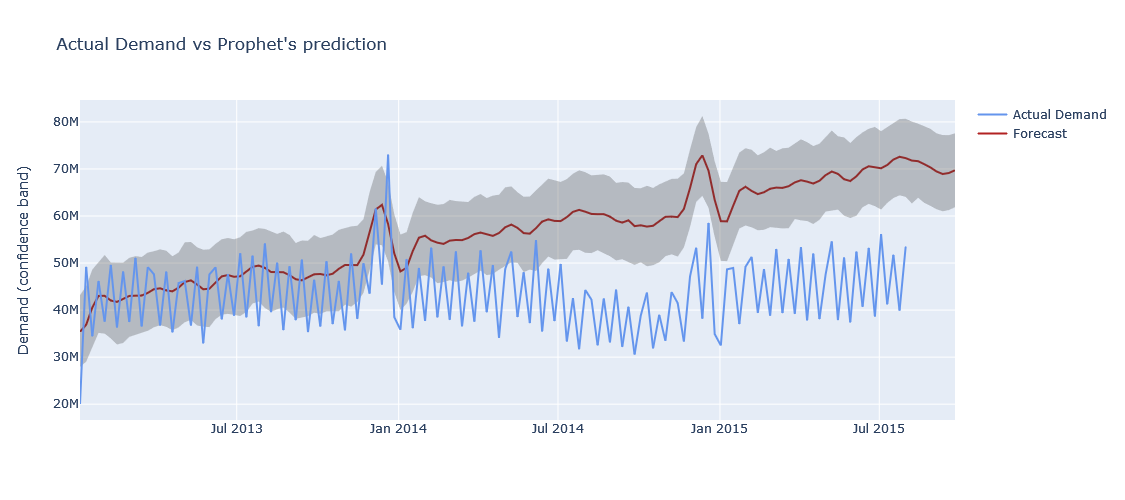

In [48]:
get_plot_prediction_from(forecast=forecast3, actual = subsales_macro)

In [49]:
actual = subsales_macro.y
fitted = forecast3.yhat[:length]
get_forecast_evaluation(actual=actual, fitted=fitted)['R-RMSE']

0.3835477405366182

__Conclusion:__
- The model gives `R-RSME = 0.3835` (rounding numbers 38.4 %).
- The model with `Inflation_rate` and `RPI_Pharmacy` as a regressor is performing worst than the previous models. It doubles the difference between predicted and actual values.
- It is terrible at predicting and should be avoided. The conclusion is to refuse the `RPI_Pharmacy` as regressor. 
- Notice that even `RPI_Pharmacy` and `Sales` are not correlated, as a regressor, it disturbs the model dramatically

### Forecasting Models with Weather features using Prophet

In [50]:
subsales_weather = sales_weather[['Date', 'Sales', 'Mean_TemperatureC', 'Mean_Humidity', 'Precipitationmm']]
subsales_weather.rename(columns={'Date': 'ds', 'Sales': 'y'}, inplace=True)

In [51]:
subsales_weather.set_index('ds', inplace=True)
subsales_weather = subsales_weather.resample('W-Fri').agg({'y': np.sum,
                                                           'Mean_TemperatureC': np.mean, 
                                                           'Mean_Humidity': np.mean,
                                                           'Precipitationmm': np.sum})

In [52]:
# Global variables for evaluating and predicting
subsales_weather.reset_index(inplace=True)
length = len(subsales_weather.y)

#### Predicting with Mean Temperature as regressor

In most of Germany, the climate is moderately continental, characterized by cold winters, with average daily temperatures around 0 °C or slightly above, and warm summers, with maximum temperatures around 22/24 °C in July and August.

In Germany, there are four defined season: spring, summer, autum and winter. The different regions have small variations on the events and might have higher or lower average temperatures. The level of aggregation by state in the data will give a better understanding of it.

Description of the model:
1. Prophet model with confidence interval: `75%`
2. Predicted Variable: `Sales`
3. Regressors: `Mean_TemperatureC`
3. Periods: 6 weeks ahead

In [53]:
model = Prophet(interval_width = 0.75)

# add Inflation_rate as a regressor
model.add_regressor('Mean_TemperatureC')

# fit the model
model.fit(subsales_weather)

# dataFrame for the prediction
future = model.make_future_dataframe(periods=56)
future['Mean_TemperatureC'] = weather['Mean_TemperatureC']
future = future.set_index('ds').resample('W-Fri').mean()
future.reset_index(inplace=True)

forecast1 = model.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


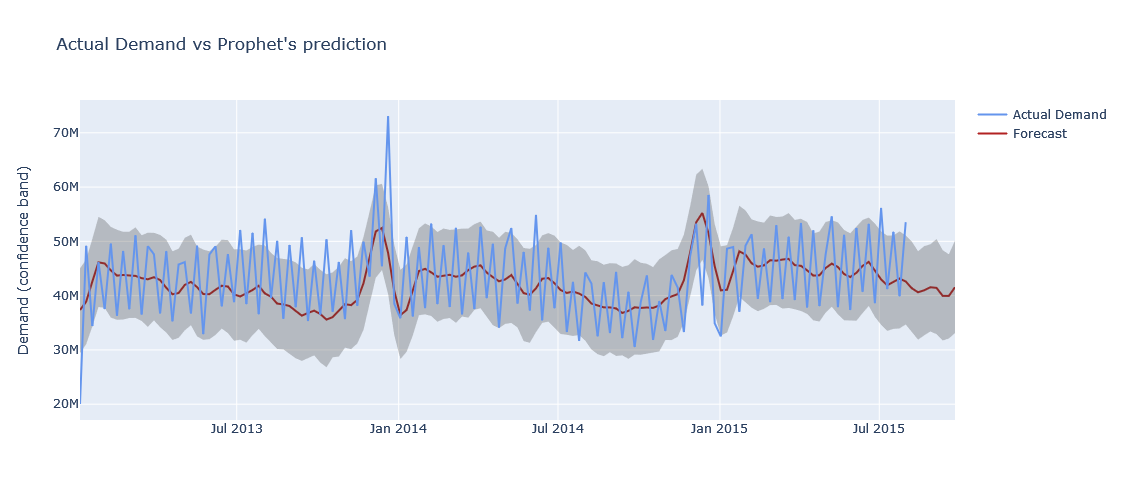

In [54]:
get_plot_prediction_from(forecast=forecast1, actual = subsales_weather)

In [55]:
actual = subsales_macro.y
fitted = forecast1.yhat[:length]
get_forecast_evaluation(actual=actual, fitted=fitted)['R-RMSE']

0.17418040502116666

__Conclusion:__
- The model gives `R-RSME = 0.1741` (rounding numbers 17.4 %).
- The model with `Mean_TemperatureC` as a regressor is performing sligthtly worse, by a marginal 0.6 % than the model without regressors used as benchmarks.
- It can be considered as a good model still

#### Predicting with Precipitation in mm  regressor

The set for the weather has the information of the precipitation in mm on a particular day. The information given is aggregated into states. This might not reflect the overall effect in stores in a city since such a granular information is missed from the data.

In Germany, rainfall is to be expected from June to August, though it’s not unheard of at other times of the year. In the Exploratory Data Analysis, these months exhibits a different flat pattern, at the end of these months there is an inflection point in trend. Therefore, it is included in the analysis as regressor

Description of the model:
1. Prophet model with confidence interval: `75%`
2. Predicted Variable: `Sales`
3. Regressors: `Precipitationmm`
3. Periods: 6 weeks ahead

In [56]:
model = Prophet(interval_width = 0.75)

# add Inflation_rate as a regressor
model.add_regressor('Precipitationmm')

# fit the model
model.fit(subsales_weather)

# dataFrame for the prediction
future = model.make_future_dataframe(periods=56)
future['Precipitationmm'] = weather['Precipitationmm']
future = future.set_index('ds').resample('W-Fri').sum()
future.reset_index(inplace=True)

forecast2 = model.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


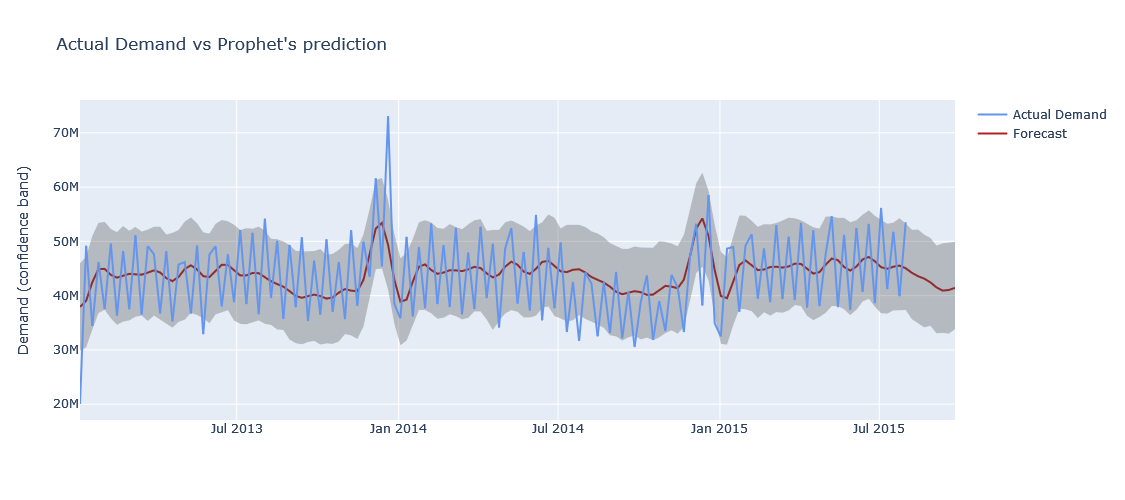

In [57]:
get_plot_prediction_from(forecast=forecast2, actual = subsales_weather)

In [58]:
actual = subsales_macro.y
fitted = forecast2.yhat[:length]
get_forecast_evaluation(actual=actual, fitted=fitted)['R-RMSE']

0.16881797421530564

__Conclusion:__
- The model gives `R-RSME = 0.1688` (rounding numbers 16.9 %).
- The model with `Precipitationmm` as a regressor is performing sligthtly worse, by a marginal 0.008 % than the model without regressors used as benchmarks.
- `Precipitationmm` as regressor performs better (by small 0.001) than `Inflation_rate` did as regressor.

### Forecasting Models with Visitors and Frequency features using Prophet

In [59]:
subsales_visitors = sales_visitors[['Date', 'Sales', 'Visitors', 'VisitorsPerMinute', 'SalesPerVisitor']]
subsales_visitors.rename(columns={'Date': 'ds', 'Sales': 'y'}, inplace=True)

In [60]:
subsales_visitors.set_index('ds', inplace=True)
subsales_visitors = subsales_visitors.resample('W-Fri').agg({'y': np.sum,
                                                             'Visitors': np.sum, 
                                                             'VisitorsPerMinute': np.mean,
                                                             'SalesPerVisitor': np.mean})

In [61]:
# Global variables for evaluating and predicting
subsales_visitors.reset_index(inplace=True)
length = len(subsales_weather.y)

In [62]:
subsales_visitors

ds           y  Visitors  VisitorsPerMinute  SalesPerVisitor
0   2013-01-04  20033838.0   8316235           2.756345         1.972245
1   2013-01-11  49209176.0  18084642           3.536669         2.495167
2   2013-01-18  34377516.0  14631177           2.878712         2.188168
3   2013-01-25  46210343.0  17032682           3.329592         2.516476
4   2013-02-01  37504341.0  15341634           3.009898         2.277789
..         ...         ...       ...                ...              ...
130 2015-07-03  56167940.0  18922277           3.699788         2.775242
131 2015-07-10  41175737.0  16184658           3.166783         2.405834
132 2015-07-17  51800088.0  18118684           3.539482         2.675853
133 2015-07-24  39841984.0  15655203           3.076038         2.392979
134 2015-07-31  53538454.0  18046482           3.517841         2.761684

[135 rows x 5 columns]

#### Predicting with Mean Visitors as regressor

The number of visitors here is used to perform an analysis similar to that on e-commerce. Similar to the count of the times a page has been visited or refreshed, it tracks the number of visitors a physical store has. This includes counting only individuals.

The number is not unique views, since some stores count visitors family as one visitor while others count members of a family as individuals.

Description of the model:
1. Prophet model with confidence interval: `75%`
2. Predicted Variable: `Sales`
3. Regressors: `Visitors`
3. Periods: 6 weeks ahead

In [63]:
model = Prophet(interval_width = 0.75)

# add Inflation_rate as a regressor
model.add_regressor('Visitors')

# fit the model
model.fit(subsales_visitors)

# dataFrame for the prediction
future = model.make_future_dataframe(periods=56)
future['Visitors'] = subsales_visitors['Visitors']
future = future.set_index('ds').resample('W-Fri').sum()
future.reset_index(inplace=True)

forecast1 = model.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


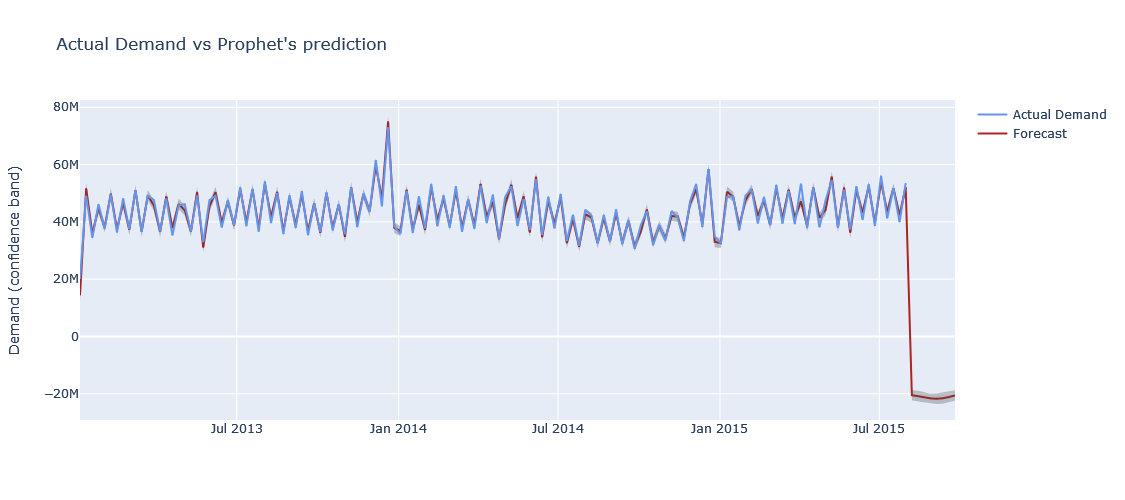

In [64]:
get_plot_prediction_from(forecast=forecast1, actual = subsales_visitors)

In [65]:
actual = subsales_macro.y
fitted = forecast1.yhat[:length]
get_forecast_evaluation(actual=actual, fitted=fitted)['R-RMSE']

0.03582125832605085

__Conclusion:__
- The model gives `R-RSME = 0.0358` (rounding numbers 3.6 %).
- The model with `Visitors` as a regressor is performing with higher precision in terms of RSME. This is understood as the high correlation it has.
- Despite the high precision, this can be considered as a good model since is moving the sales forecast task to visitors forecast. It is one an the same problem

#### Predicting with Visitors per minute regressor

This KPI consider the number of visitors a store has and divided uniformly on the open interval the store has in minutes. This might indicate a good estimator of the sales done in open time. The variable shows a strong correlation with Sales in the analysis

Description of the model:
1. Prophet model with confidence interval: `75%`
2. Predicted Variable: `Sales`
3. Regressors: `VisitorsPerMinute`
3. Periods: 6 weeks ahead

In [66]:
model = Prophet(interval_width = 0.75)

# add Inflation_rate as a regressor
model.add_regressor('VisitorsPerMinute')

# fit the model
model.fit(subsales_visitors)

# dataFrame for the prediction
future = model.make_future_dataframe(periods=56)
future['VisitorsPerMinute'] = sales_visitors['VisitorsPerMinute']
future = future.set_index('ds').resample('W-Fri').mean()
future.reset_index(inplace=True)

forecast2 = model.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


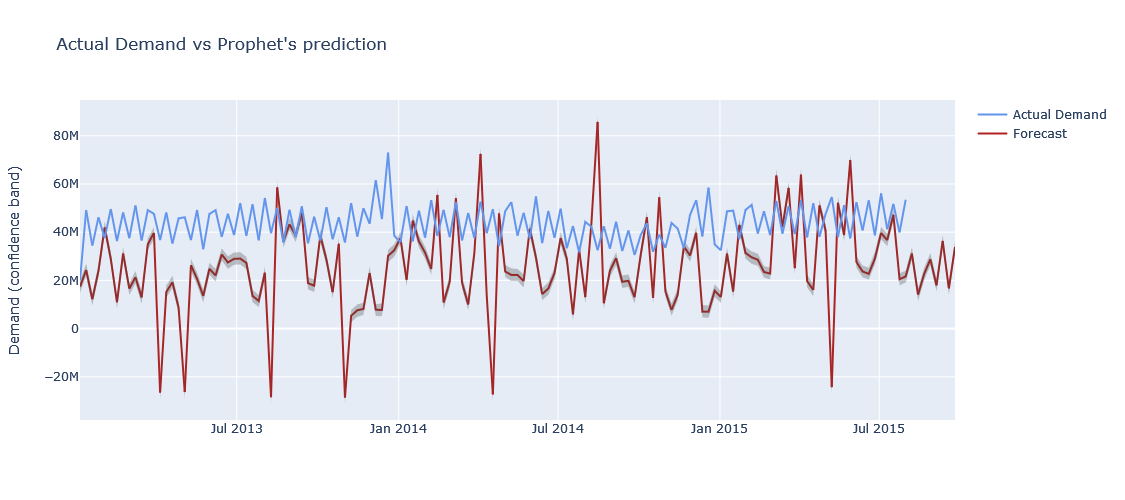

In [67]:
get_plot_prediction_from(forecast=forecast2, actual = subsales_weather)

In [68]:
actual = subsales_macro.y
fitted = forecast2.yhat[:length]
get_forecast_evaluation(actual=actual, fitted=fitted)['R-RMSE']

0.6161294961035932

__Conclusion:__
- The model gives `R-RSME = 0.6161` (rounding numbers 61.6 %).
- The model with `SalesPerVisitor` as a regressor is performing worst than guessing only. It is four times the deviation showed in the no regressor model
- One possible reason is the time scale not of aggregation time not being of the same magnitude

#### Predicting with Sales per visitor as regressor

Description of the model:
1. Prophet model with confidence interval: `75%`
2. Predicted Variable: `Sales`
3. Regressors: `SalesPerVisitor`
3. Periods: 6 weeks ahead

In [69]:
model = Prophet(interval_width = 0.75)

# add Inflation_rate as a regressor
model.add_regressor('SalesPerVisitor')

# fit the model
model.fit(subsales_visitors)

# dataFrame for the prediction
future = model.make_future_dataframe(periods=56)
future['SalesPerVisitor'] = sales_visitors['SalesPerVisitor']
future = future.set_index('ds').resample('W-Fri').mean()
future.reset_index(inplace=True)

forecast1 = model.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


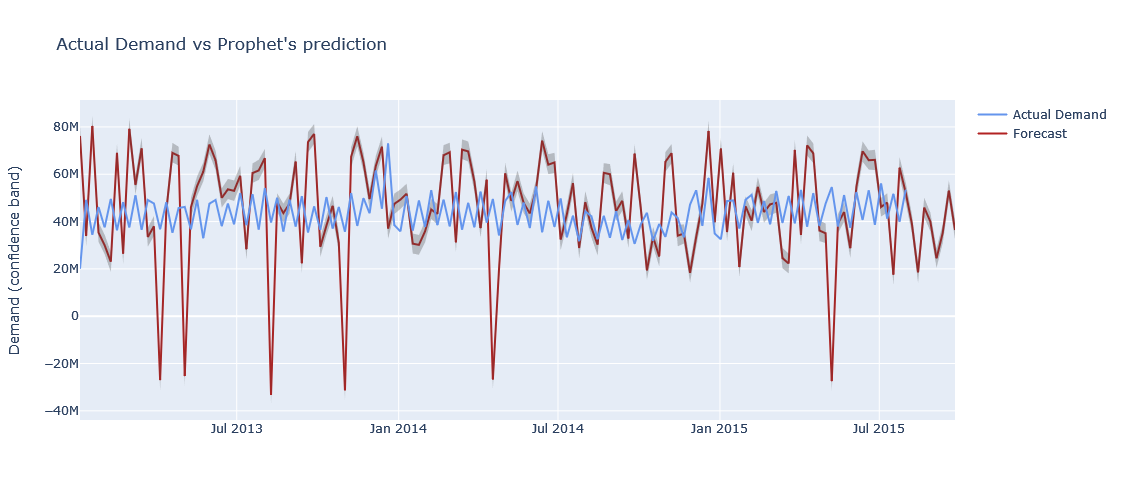

In [70]:
get_plot_prediction_from(forecast=forecast1, actual = subsales_visitors)

In [71]:
actual = subsales_macro.y
fitted = forecast1.yhat[:length]
get_forecast_evaluation(actual=actual, fitted=fitted)['R-RMSE']

0.5686865553070461

__Conclusion:__
- The model gives `R-RSME = 0.5686` (rounding numbers 56.9 %).
- The model with `SalesPerVisitor` as a regressor is worst than other models. It only performs better than the KPI `VisitorPerMinute`
- It is not the best KPI to study the problem